In [1]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

from __future__ import print_function, \
    division, \
    absolute_import

import os

import sep
import h5py

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.modeling import models, fitting

#---------------------------------------------------------------------------#
#User imports
import sys
sys.path.append('/Users/fardila/Documents/Github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
# For Kungpao
x_images = '/Users/fardila/anaconda/envs/hsc_hydro/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

In [3]:
from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')



      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |    
      |                   STSDAS Version 3.17                      |
      |                   

In [4]:
def load_pkl(filename):
    try:
        import cPickle as pickle
    except:
        warnings.warn("## cPickle is not available!!")
        import pickle
    
    if os.path.isfile(filename):
        pklFile = open(filename, 'rb')
        data = pickle.load(pklFile)    
        pklFile.close()
    
        return data
    else: 
        warnings.warn("## Can not find %s, return None" % filename)
        return None
    
    
def save_to_fits(image, name):
    """
    Save a 2-D array as fits image.
    """
    hdu = fits.PrimaryHDU(image)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(name, overwrite=True)
    
    return


def show_illustris(img_cen, img_sat, img_icl, img_all):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(2, 2, 1)
    ax1 = display_single(img_all, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax2 = plt.subplot(2, 2, 2)
    ax2 = display_single(img_cen, ax=ax2, 
                         contrast=0.10,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax3 = plt.subplot(2, 2, 3)
    ax3 = display_single(img_sat, ax=ax3, 
                         contrast=0.12,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

    ax4 = plt.subplot(2, 2, 4)
    ax4 = display_single(img_icl, ax=ax4, 
                         contrast=0.01,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
    
    return fig

In [8]:
hsc_data='/Users/fardila/Documents/Github/HSC_vs_hydro/Data/HSC/'
hscAvgProf0 = load_pkl(hsc_data+"hscAvgProf0.pkl")
hscAvgProf1 = load_pkl(hsc_data+"hscAvgProf1.pkl")
hscAvgProf2 = load_pkl(hsc_data+"hscAvgProf2.pkl")

rm0_sl, rm0_ml, rm0_aml = hscAvgProf0['all'], hscAvgProf0['med'], hscAvgProf0['avg']
rm1_sl, rm1_ml, rm1_aml = hscAvgProf1['all'], hscAvgProf1['med'], hscAvgProf1['avg']
rm2_sl, rm2_ml, rm2_aml = hscAvgProf2['all'], hscAvgProf2['med'], hscAvgProf2['avg']

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)

# These are the median stellar mass density profiles for HSC galaxies at 0.3 < z < 0.5
# in three mass bins
# rm0 : 11.4 < logM_100kpc < 11.6 
# rm1 : 11.6 < logM_100kpc < 11.8 
# rm2 : 11.8 < logM_100kpc < 12.0 
# They are on a common radius array, and we use (r ** 0.25) as radius

# Load the Illustris stellar mass maps

In [9]:
illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/galaxies_star_maps.hdf5'

# Load general simulation and galaxy properties
f = h5py.File(illustris_file, 'r')
snap_a = f.attrs['snap_a']
n_galaxies = len(f['cat_sh_id'])
sh_idx = np.array(f['cat_sh_id'])
grp_idx = np.array(f['cat_grp_id'])
cat_is_primary = np.array(f['cat_grp_is_primary'])
cat_sh_mstar = np.array(f['cat_sh_mstar'])
cat_sh_pos_bound = np.array(f['cat_sh_pos_bound'])
cat_sh_halfmrad_stars = np.array(f['cat_sh_halfmrad_stars'])

map_stars = np.array(f['map_stars'])
map_size = f['map_stars_size'].value
n_pixels = f['map_stars_npixel'].value
f.close()

In [10]:
# 10 galaxies, 3 maps (galaxy, surrounding, diffuse), 
#  3 projections (xy, xz, yz), 200 x 200 images
#  1 pixel = 3 kpc
map_stars.shape

pixel_scale = 3.0 # kpc / pixel

# Use Galaxy 1 Projection xy as example

12.5205 12.4234123714


/Users/fardila/Documents/Github/kungpao/kungpao/display.py:153: RuntimeWarning: divide by zero encountered in log10
  img_scale = np.log10(img)


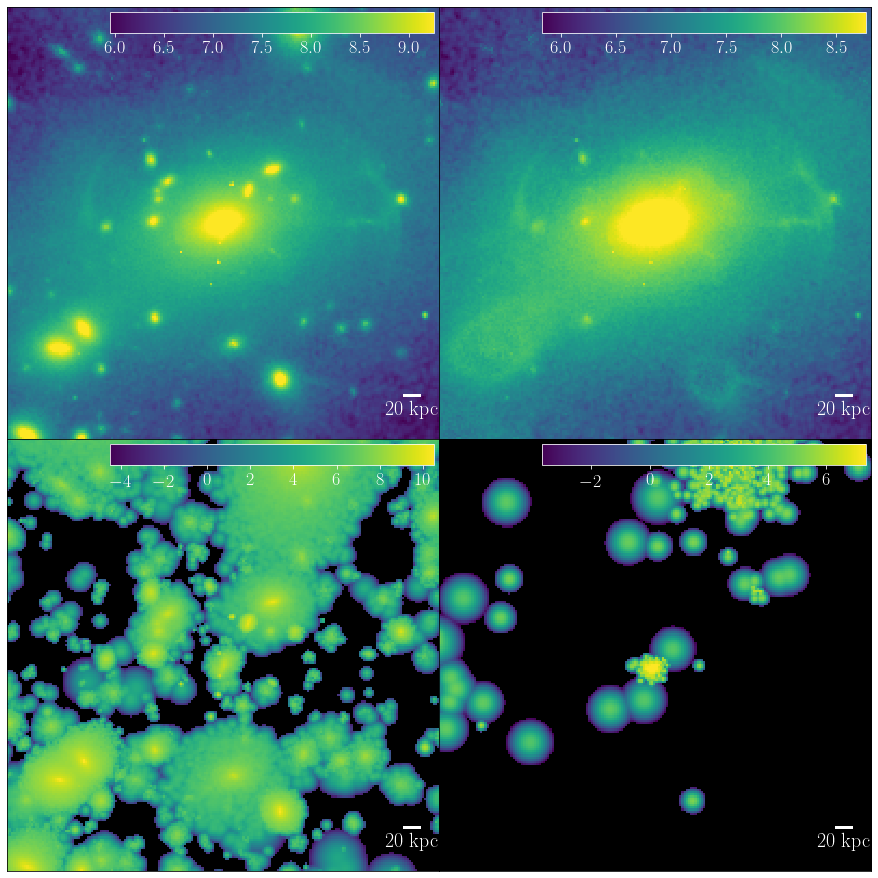

In [11]:
img_cen = map_stars[0, 0, 1] * (pixel_scale ** 2) # Central 
img_sat = map_stars[0, 1, 1] * (pixel_scale ** 2) # Satellites
img_icl = map_stars[0, 2, 1] * (pixel_scale ** 2) # Diffuse
img_cen_icl = (img_cen + img_icl)           # Central + Diffuse
img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse
# We convert the image into unit of stellar mass instead of mass density

log_mstar = np.log10(cat_sh_mstar[0])
log_mcen = np.log10(np.sum(img_cen))
print(log_mstar, log_mcen)

fits_prefix = 'illustris_1_xy'

save_to_fits(img_cen, fits_prefix + '_cen.fits')
save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
save_to_fits(img_all, fits_prefix + '_all.fits')

_ = show_illustris(img_cen, img_sat, img_icl, img_all)


## Step 0: Measure the profiles on the central only image

# Mean Sky / RMS Sky = 15031176.00000 / 2641315.50000
# Detect 1 objects
[ 99.58306406] [ 99.51233175]


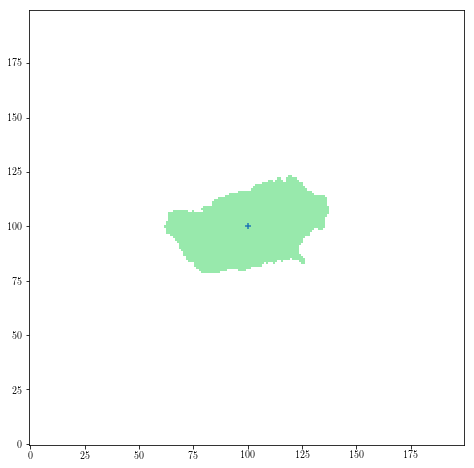

In [12]:
# First, do a simple detection and find the center of the central galaxy 

# Measure the background,
# Here on the image has no noise and has a lot of diffuse features
# so measure sky using a very small box (bw, bh values) helps us remove 
# a lot of the them, make the detection easier
# See: http://sep.readthedocs.io/en/v1.0.x/api/sep.Background.html#sep.Background 
# For more details
bkg_cen = sep.Background(img_cen, 
                         bw=10, bh=10, 
                         fw=5, fh=5)
print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_cen.globalback, bkg_cen.globalrms))

# Object detection after subtracting the background
# Since there is no noise on the image, we will just use the global RMS 
# from the background estimate as error
# Here, we use very high threshold, less aggressive deblending method to 
# make the detection focuses on the big object
objs_cen, seg_cen = sep.extract(img_cen - bkg_cen.back(), 
                                20.0,
                                err=bkg_cen.globalrms,
                                minarea=1000,
                                deblend_nthresh=24, 
                                deblend_cont=0.1,
                                segmentation_map=True)

# And this is how you turn the segmentation image into a mask
# You can remove certain object from the segmentation map first
seg_mask = (seg_cen > 0)
print("# Detect %d objects" % len(objs_cen))

plt.figure(figsize=(8, 8))
plt.imshow(seg_cen, origin='lower', cmap=SEG_CMAP, 
           alpha=1.0)
plt.scatter(objs_cen['xcpeak'], objs_cen['ycpeak'], marker='+')

print(objs_cen['x'], objs_cen['y'])

In [13]:
# This is how we run surface brightness profile extraction 

# This process will generate some output files
# The outputs are:  [An Astropy table for the isophotes table] [Name of the output binary file]

# galSBP can fit the profiles in 4 ways:
# stage = 1 : leave the center and the shape (ellipticity and PA) of the isophote free
# stage = 2 : fix the center, leave only the shape (ellipticity and PA) of the isophote free
# stage = 3 : fix the geometry of the isophote, extract the profile
# stage = 4 : extract the profile using a pre-defined profile (using a out)

# For now, you need the following parameters:
# galX, galY: central coordinate (initial values or fixed at these values)
# galQ, galPA: axis ratio, position angle (degree) (initial values or fixed at these values)
# iniSma [pix]: stars the fitting at this radius 
# maxSma [pix]: maximum radius for profile extraction
# ellipStep: step size for the profile, smaller value means finer profile


# Free center and geometry
iso_cen_1, iso_cen_1_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=objs_cen[0]['x'], 
                                         galY=objs_cen[0]['y'], 
                                         galQ=(objs_cen[0]['b'] / objs_cen[0]['a']), 
                                         galPA=(objs_cen[0]['theta'] * 180.0 / np.pi), 
                                         maxSma=150, 
                                         iniSma=10.0, 
                                         stage=1, 
                                         intMode='median', 
                                         ellipStep=0.1,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         savePng=False, verbose=True)

print('# Output file : %s' % iso_cen_1_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_1['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  99.5830640558 99.5123317515
###      galR :  20.0
###      iniSma, maxSma :  10.0 150
###      Stage :  1
###      Step :  0.1
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_NNZG4.fits
###      Output Binary : illustris_1_xy_cen_ellip_1.bin
----------------------------------------------------------------------------------------------------
------------

In [14]:
# The output is a Astropy table
# The useful information is: 
# sma [pix] : radius along the major axis 
# intens / int_err : intensitiy and its error, here is in unit of stellar mass per pixel
# x0 / y0 / x0_err / y0_err : central coordinates and errors 
# ell / ell_err : ellipticity of the isophote 
# pa / pa_err : position angle of the isophote 
# avg_x0 / avg_y0 / avg_q / avg_pa : intensity-weighted mean central coordinate, axis ratio
#                                    and position angle in the inner region of the profile
# growth_ori : curve-of-growth value, the total stellar mass within this isophote via integration.

iso_cen_1

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,33377540000.0,nan,nan,nan,nan,nan,nan,nan,100.6696,nan,100.7299,nan,-3650578000.0,nan,nan,0.0,-26.30864,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-23.923029539,-23.923029539,-23.923029539,33377540000.0,0.0,nan,nan,nan,0.0,0.0,0.0,0.0,100.512785145,100.554729875,0.684646977473,-71.4255137465,0.0,33377540000.0,-23.923029539,0.0,150.211804122,-30.9290423608,-30.9290423608,-30.9290423608
0.5209865,31475640000.0,59600752.0,303905408.0,214893568.0,0.3467576,0.05377561,-64.8426,5.558491,100.6696,0.02037765,100.7299,0.01596349,-4738982000.0,2166844000.0,0.4572383,0.8495846,-26.24494,0.002057406,0.002054404,33377540000.0,33377540000.0,-26.30864,-26.30864,1.0,1.0,0.02823134,0.038448,0.02506818,0.03665183,0.09007892,0.04647302,0.02492092,0.02348268,13,0,200.0,2.0,17222.34,2.0,1793889.0,52724548.0,-831083.6,50966004.0,3739321.0,52765216.0,-251116.8,50912220.0,-64.8426,-23.8593301501,-23.8593301501,-23.8593301501,31475640000.0,0.0,0.00205395362844,-23.8613841037,-23.8572761964,1.5629595,1.11811617755,0.0,0.0,100.512785145,100.554729875,0.684646977473,-71.4255137465,0.0,31475640000.0,-23.8593301501,0.0,150.211804122,-30.9290423608,-30.9290423608,-30.9290423608
0.5730851,31448760000.0,62011656.0,316198656.0,223586208.0,0.3861487,0.04666101,-63.0414,4.436802,100.6328,0.0204152,100.7045,0.01578787,-4857291000.0,1972268000.0,0.4060428,0.8700712,-26.24401,0.002143185,0.00213858,33377540000.0,33377540000.0,-26.30864,-26.30864,1.0,1.0,-0.005099333,0.0350846,0.01039006,0.03393012,0.06649652,0.03727776,0.03785771,0.02893785,13,0,200.0,2.0,32336.71,2.0,1652060.0,70969664.0,-4371542.0,68602592.0,3394472.0,71023088.0,-3795197.0,68528928.0,-63.0414,-23.858402542,-23.858402542,-23.858402542,31448760000.0,0.0,0.00213878089742,-23.8605413229,-23.8562637611,1.7192553,1.14507805843,2400570661.37,2400570661.37,100.512785145,100.554729875,0.684646977473,-71.4255137465,0.0,31448760000.0,-23.858402542,2400570661.37,150.211804122,-30.9290423608,-30.9290423608,-30.9290423608
0.6303936,31450630000.0,70250728.0,358209856.0,253292608.0,0.4294351,0.04050636,-61.64769,3.558803,100.5902,0.02068115,100.6777,0.01574368,-5354742000.0,1883217000.0,0.3516915,0.8910518,-26.24407,0.002428384,0.002421988,33377540000.0,33377540000.0,-26.30864,-26.30864,1.0,1.0,-0.03245284,0.03316149,-0.009341986,0.03010925,0.04025734,0.02955363,0.03779102,0.02808901,13,0,200.0,2.0,30599.73,2.0,1057541.0,86866048.0,-5116595.0,83968776.0,2146605.0,86938392.0,-4729304.0,83885312.0,-61.64769,-23.8584670999,-23.8584670999,-23.8584670999,31450630000.0,0.0,0.00242248564663,-23.8608895855,-23.8560446142,1.8911808,1.17269011006,4884056536.87,4884056536.87,100.512785145,100.554729875,0.684646977473,-71.4255137465,0.0,31450630000.0,-23.8584670999,4884056536.87,150.211804122,-30.9290423608,-30.9290423608,-30.9290423608
0.693433,31386010000.0,55021120.0,280553760

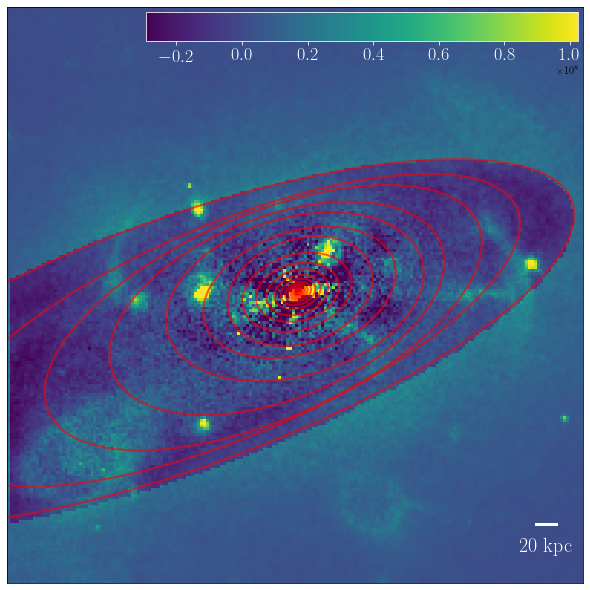

In [15]:
# Here, we use the stsdas.isophote.analysis.bmodel function to reconstruct 
# a 2-D model using the isophote information 
# So that we can subtract it from the original image, and see how well it does.

try: 
    os.remove(fits_prefix + '_cen_ellip_1.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_1_bin,
            output=fits_prefix + '_cen_ellip_1.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_1 = fits.open(fits_prefix + '_cen_ellip_1.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_1, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_1_ellip = galSBP.convIso2Ell(iso_cen_1)
for ii, e in enumerate(iso_cen_1_ellip):
    if (ii % 3 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# Here, we can see the model becomes off-center quickly, and it reveals many 
# diffuse features underneath. 

Text(0.5,0,u'$\\mathrm{SMA}$')

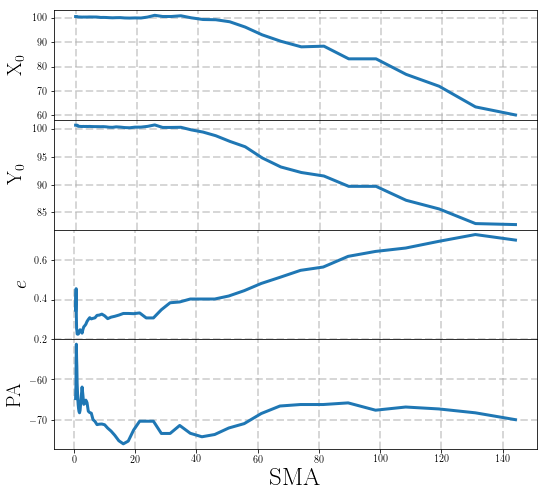

In [16]:
# Normally it is better to also check the profiles for geometry 

# Here you can see the central location changes with radius dramatically, 
# that tells you the image is asymmetric....which unfortunately makes the 
# profile extraction harder. 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_1['sma'], iso_cen_1['x0'], linewidth=3.0)
ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_1['sma'], iso_cen_1['y0'], linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_1['sma'], iso_cen_1['ell'], linewidth=3.0)
ax3.set_ylabel(r'$e$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_1['sma'], iso_cen_1['pa'], linewidth=3.0)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

In [17]:
# Now, let's fixe the center, and let the geometry to be free

iso_cen_2, iso_cen_2_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=0.6, 
                                         galPA=-50.0, 
                                         maxSma=220, 
                                         iniSma=10.0, 
                                         stage=2, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=False,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_2_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_2['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  10.0 220
###      Stage :  2
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_98DRV.fits
###      Output Binary : illustris_1_xy_cen_ellip_2.bin
----------------------------------------------------------------------------------------------------
---------------------------

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1614: RuntimeWarning: divide by zero encountered in log10
  expTime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1614: RuntimeWarning: invalid value encountered in log10
  expTime))


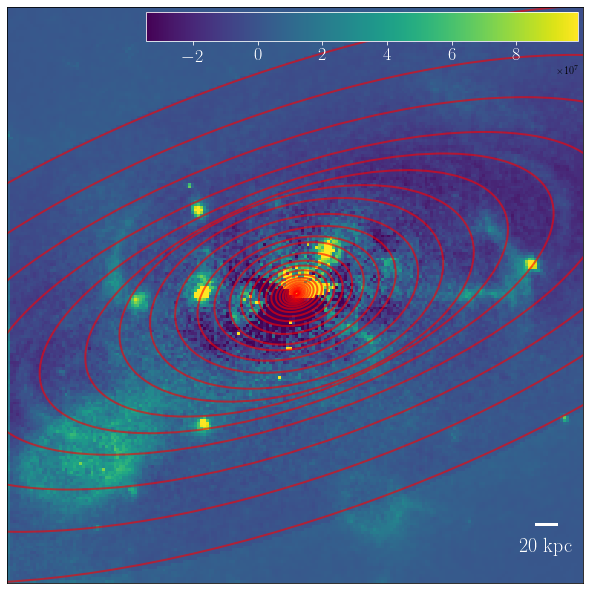

In [18]:
try: 
    os.remove(fits_prefix + '_cen_ellip_2.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_2_bin,
            output=fits_prefix + '_cen_ellip_2.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_2 = fits.open(fits_prefix + '_cen_ellip_2.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_2, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_2_ellip = galSBP.convIso2Ell(iso_cen_2)
for ii, e in enumerate(iso_cen_2_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

# It seems that this galaxy is still not relaxed, and the central region is 
# highly asymmetric...

# You can try to change the central location, or the initial values of the parameters
# the situation is the same...tough case

Text(0.5,0,u'$\\mathrm{SMA}$')

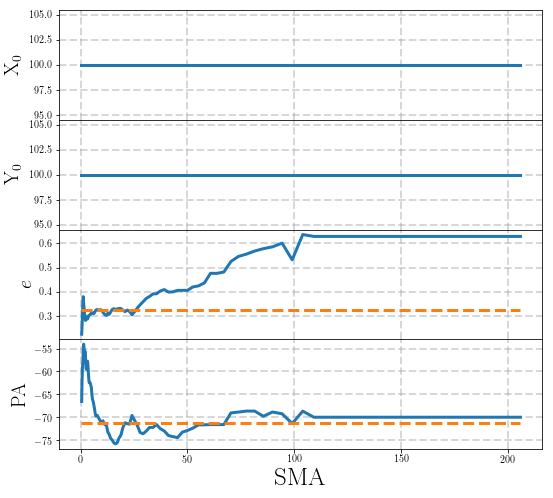

In [19]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_2['sma'], iso_cen_2['x0'], linewidth=3.0)
ax1.set_ylabel(r'$\mathrm{X}_0$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_2['sma'], iso_cen_2['y0'], linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Y}_0$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_2['sma'], iso_cen_2['ell'], linewidth=3.0)
ax3.plot(iso_cen_2['sma'], (1.0 - iso_cen_2['avg_q']), 
         linestyle='--', linewidth=3.0)
ax3.set_ylabel(r'$e$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_2['sma'], iso_cen_2['pa'], linewidth=3.0)
ax4.set_ylabel(r'$\mathrm{PA}$', fontsize=20)
ax4.plot(iso_cen_2['sma'], iso_cen_2['avg_pa'],
         linestyle='--', linewidth=3.0)
ax4.set_xlabel(r'$\mathrm{SMA}$', fontsize=25)

Text(0.5,0,u'$\\mathrm{SMA/Pixel}^{1/4}$')

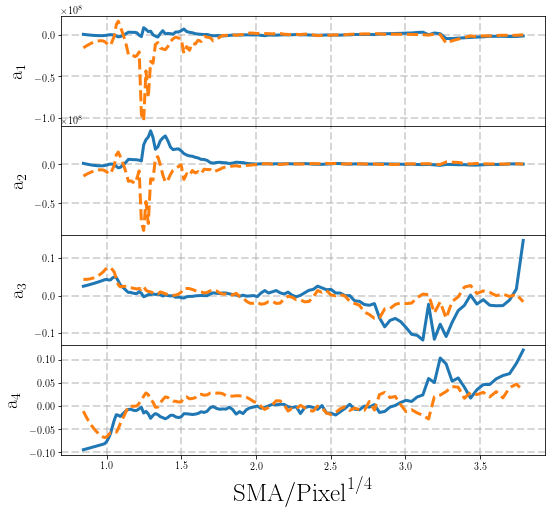

In [20]:
# When fitting the isophotes, we can add Fourier components to make it more flexible
# Here we can show the normalized amplitudes of the first four Fourier components. 

# Here, the bumpy features for A1 and A2 reflect the asymmetric feature.
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(4, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a1'], linewidth=3.0)
ax1.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b1'], linewidth=3.0, linestyle='--')
ax1.set_ylabel(r'$\mathrm{a}_1$', fontsize=20)

ax2 = plt.subplot(4, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a2'], linewidth=3.0)
ax2.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b2'], linewidth=3.0, linestyle='--')
ax2.set_ylabel(r'$\mathrm{a}_2$', fontsize=20)

ax3 = plt.subplot(4, 1, 3)
ax3.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a3'], linewidth=3.0)
ax3.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b3'], linewidth=3.0, linestyle='--')
ax3.set_ylabel(r'$\mathrm{a}_3$', fontsize=20)

ax4 = plt.subplot(4, 1, 4)
ax4.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['a4'], linewidth=3.0)
ax4.plot(iso_cen_2['sma'] ** 0.25, iso_cen_2['b4'], linewidth=3.0, linestyle='--')
ax4.set_ylabel(r'$\mathrm{a}_4$', fontsize=20)
ax4.set_xlabel(r'$\mathrm{SMA/Pixel}^{1/4}$', fontsize=25)

In [21]:
# Now, let's fix everything

iso_cen_3, iso_cen_3_bin = galSBP.galSBP('illustris_1_xy_cen.fits', 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=iso_cen_2['avg_q'][0], 
                                         galPA=iso_cen_2['avg_pa'][0], 
                                         maxSma=250, 
                                         iniSma=50.0, 
                                         stage=3, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=True,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_3_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_3['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen.fits
###      Input Image   : temp_PBS5E.fits
###      Output Binary : illustris_1_xy_cen_ellip_3.bin
----------------------------------------------------------------------------------------------------
---------------------------

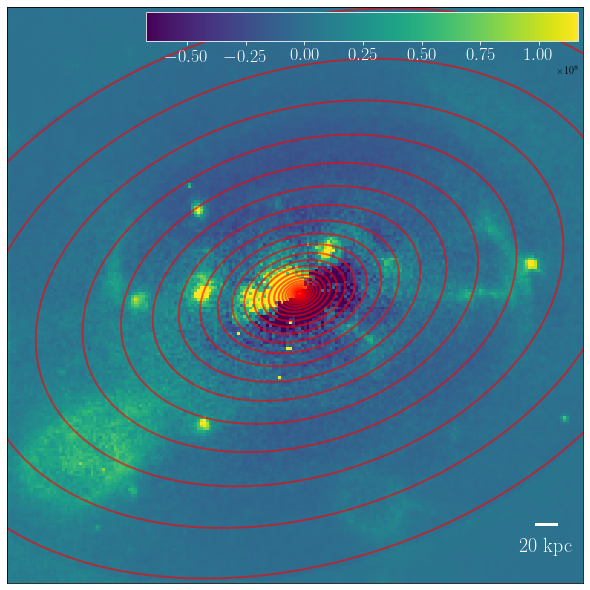

In [22]:
try: 
    os.remove(fits_prefix + '_cen_ellip_3.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen.fits', 
            table=iso_cen_3_bin,
            output=fits_prefix + '_cen_ellip_3.fits',
            minsma=0.0,
            highar='no')

img_cen_ellip_3 = fits.open(fits_prefix + '_cen_ellip_3.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen - img_cen_ellip_3, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_3_ellip = galSBP.convIso2Ell(iso_cen_3)
for ii, e in enumerate(iso_cen_3_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


(1.0, 4.5)

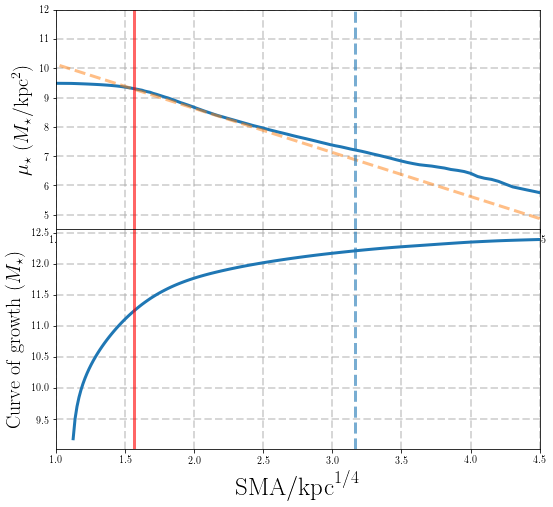

In [23]:
# Here is the 1-D mass density profile and the curve-of-growth of mass 

# I label the 6.0 kpc (twice the pixel size, not resolved within) and 100 kpc radius
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / 9), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0)
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(dev(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['growth_ori']), linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax2.set_xlim(1.0, 4.5)

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


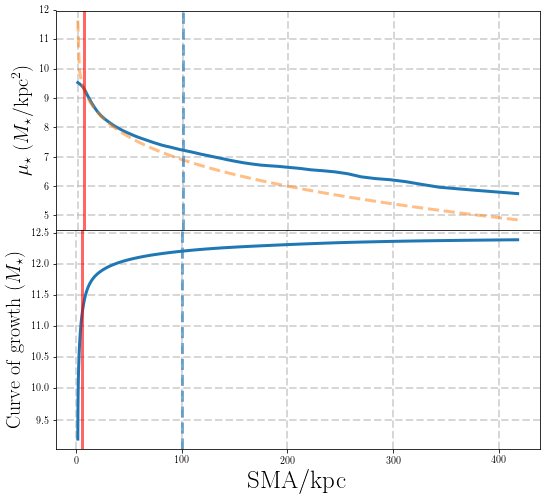

In [24]:
# And the difference becomes much more obvious when the X-axis is linear 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_3['intens'] / 9), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_3['sma'] * 3.0), 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0)
ax1.plot((iso_cen_3['sma'] * 3.0), 
         np.log10(dev(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#ax1.set_xlim(1.0, 4.5)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot((iso_cen_3['sma'] * 3.0), 
         np.log10(iso_cen_3['growth_ori']), linewidth=3.0)
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}$', fontsize=25)
ax2.axvline(100.0, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
#ax2.set_xlim(1.0, 4.5)

In [25]:
fitter = fitting.LevMarLSQFitter()
r_mask = (iso_cen_3['sma'] * 3.0 > 6.0)
xx = iso_cen_3['sma'][r_mask]
yy = iso_cen_3['intens'][r_mask] / 9.0

# Let try to fit a Sersic function
ser1_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 9.0), 
                            r_eff=6.5, n=6.0)
ser1_fit = fitter(ser1_init, xx, yy)
print("# 1-Sersic model:")
print(ser1_fit.r_eff * 3.0, ser1_fit.n)

# Let try to fit 2-Sersic functions then
ser2_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 8.0), 
                            r_eff=2.5, n=3.0) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 12.0), 
                            r_eff=20.5, n=2.0)
ser2_fit = fitter(ser2_init, xx, yy)
print("\n# 2-Sersic model:")
print(ser2_fit.r_eff_0 * 3.0, ser2_fit.n_0)
print(ser2_fit.r_eff_1 * 3.0, ser2_fit.n_1)

# Let try to fit 3-Sersic functions then
ser3_init = models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 6.0), 
                            r_eff=2.5, n=2.0) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 10.0), 
                            r_eff=12.5, n=1.5) + \
            models.Sersic1D(amplitude=np.nanmedian(iso_cen_3['intens'] / 15.0), 
                            r_eff=25.5, n=1.0)
ser3_fit = fitter(ser3_init, xx, yy)
print("\n# 3-Sersic model:")
print(ser3_fit.r_eff_0 * 3.0, ser3_fit.n_0)
print(ser3_fit.r_eff_1 * 3.0, ser3_fit.n_1)
print(ser3_fit.r_eff_2 * 3.0, ser3_fit.n_2)

# 1-Sersic model:
17.4413221353 Parameter('n', value=2.5149628639)

# 2-Sersic model:
7.5979879325 Parameter('n_0', value=0.614318151451)
37.31075924 Parameter('n_1', value=2.40853570738)

# 3-Sersic model:
7.53932893849 Parameter('n_0', value=0.575539784754)
33.8400513909 Parameter('n_1', value=2.31607122388)
4.48402709022 Parameter('n_2', value=1.21877403452)


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/astropy/modeling/functional_models.py:765: RuntimeWarning: invalid value encountered in power
  -cls._gammaincinv(2 * n, 0.5) * ((r / r_eff) ** (1 / n) - 1)))


(1.0, 4.5)

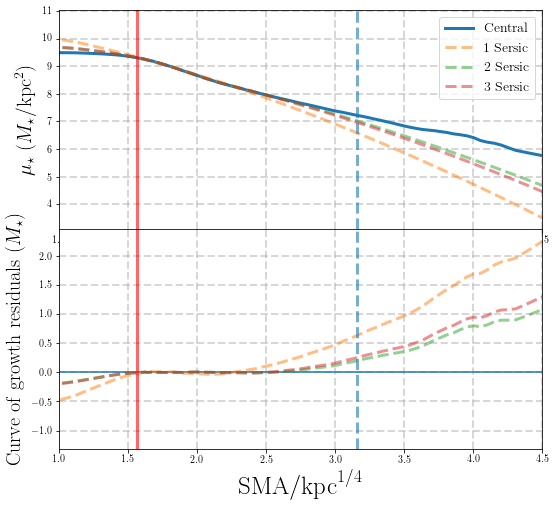

In [26]:
fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0,
         label=r'$\mathrm{Central}$')
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(ser1_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{1\ Sersic}$')
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(ser2_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{2\ Sersic}$')
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(ser3_fit(iso_cen_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{3\ Sersic}$')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)
ax1.legend(fontsize=14)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot([0.0, 4.5], [0.0, 0.0])
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (np.log10(iso_cen_3['intens'] / 9.0) - 
          np.log10(ser1_fit(iso_cen_3['sma']))), 
         linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{1\ Sersic}$')
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (np.log10(iso_cen_3['intens'] / 9.0) - 
          np.log10(ser2_fit(iso_cen_3['sma']))), 
         linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{2\ Sersic}$')
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (np.log10(iso_cen_3['intens'] / 9.0) - 
          np.log10(ser3_fit(iso_cen_3['sma']))), 
         linewidth=3.0, alpha=0.5,
         linestyle='--', label=r'$\mathrm{3\ Sersic}$')
ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth\ residuals}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax2.set_xlim(1.0, 4.5)

# Repeat for central + ICL 

# Mean Sky / RMS Sky = 15035310.00000 / 2641315.50000
# Detect 1 objects
[ 99.58213406] [ 99.50848219]


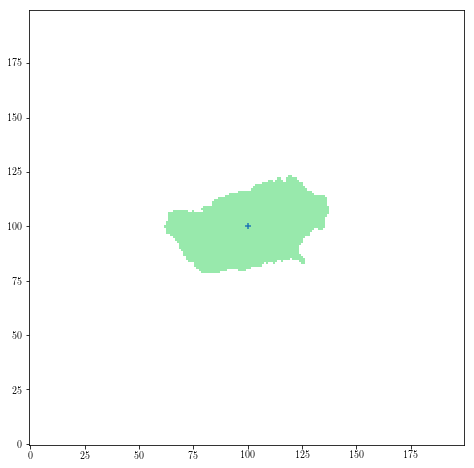

In [27]:
# First, do a simple detection and find the center of the central galaxy 

# Measure the background,
bkg_cen_icl = sep.Background(img_cen_icl, 
                         bw=10, bh=10, 
                         fw=5, fh=5)
print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_cen_icl.globalback, bkg_cen_icl.globalrms))

# Object detection after subtracting the background

objs_cen_icl, seg_cen_icl = sep.extract(img_cen_icl - bkg_cen_icl.back(), 
                                20.0,
                                err=bkg_cen_icl.globalrms,
                                minarea=1000,
                                deblend_nthresh=24, 
                                deblend_cont=0.1,
                                segmentation_map=True)

# And this is how you turn the segmentation image into a mask
# You can remove certain object from the segmentation map first
seg_mask = (seg_cen_icl > 0)
print("# Detect %d objects" % len(objs_cen_icl))

plt.figure(figsize=(8, 8))
plt.imshow(seg_cen_icl, origin='lower', cmap=SEG_CMAP, 
           alpha=1.0)
plt.scatter(objs_cen_icl['xcpeak'], objs_cen_icl['ycpeak'], marker='+')

print(objs_cen_icl['x'], objs_cen_icl['y'])

In [28]:
#stage 3 photometry
iso_cen_icl_3, iso_cen_icl_3_bin = galSBP.galSBP('illustris_1_xy_cen_icl.fits', 
                                         galX=100.0, 
                                         galY=100.0, 
                                         galQ=iso_cen_2['avg_q'][0], 
                                         galPA=iso_cen_2['avg_pa'][0], 
                                         maxSma=250, 
                                         iniSma=50.0, 
                                         stage=3, 
                                         intMode='median', 
                                         ellipStep=0.05,
                                         pix=3.0, 
                                         zpPhoto=0.0,
                                         harmonics='1 2 3 4',
                                         isophote=x_isophote, 
                                         xttools=x_ttools,
                                         recenter=True,
                                         savePng=False, 
                                         verbose=True)

print('# Output file : %s' % iso_cen_icl_3_bin)
print('# Total stellar mass from the profile: logM = %7.4f' % (iso_cen_icl_3['mag_tot'][0] / -2.5))

----------------------------------------------------------------------------------------------------
###      galX, galY :  100.0 100.0
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : illustris_1_xy_cen_icl.fits
###      Input Image   : temp_2QQS7.fits
###      Output Binary : illustris_1_xy_cen_icl_ellip_3.bin
----------------------------------------------------------------------------------------------------
-------------------

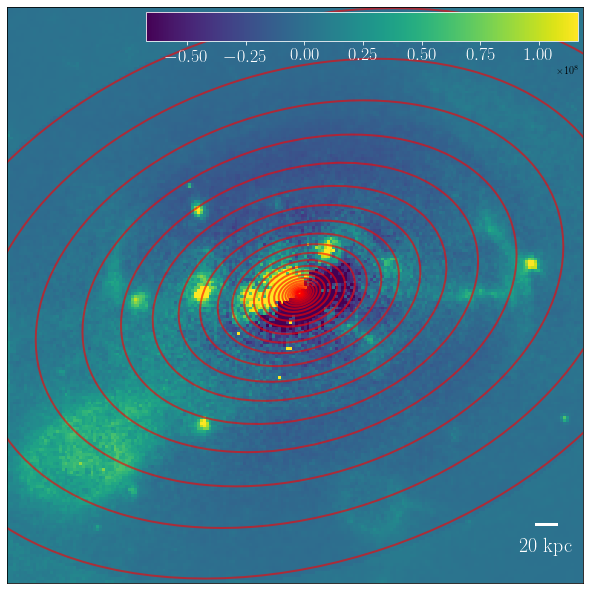

In [29]:
#ellipses
try: 
    os.remove(fits_prefix + '_cen_icl_ellip_3.fits')
except Exception: 
    pass

iraf.bmodel(parent=fits_prefix + '_cen_icl.fits', 
            table=iso_cen_icl_3_bin,
            output=fits_prefix + '_cen_icl_ellip_3.fits',
            minsma=0.0,
            highar='no')

img_cen_icl_ellip_3 = fits.open(fits_prefix + '_cen_icl_ellip_3.fits')[0].data

fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.0, bottom=0.0,
                    top=1.0, right=1.0)
ax1 = fig.add_subplot(1, 1, 1)

ax1 = display_single(img_cen_icl - img_cen_icl_ellip_3, 
                     ax=ax1,
                     contrast=0.15,
                     scale_bar_length=20.0,
                     scale_bar_loc='right',
                     stretch='linear',
                     pixel_scale=1.0,
                     physical_scale=3.0,
                     color_bar=True)

# Overplot a subsample of isophotes on the image
iso_cen_icl_3_ellip = galSBP.convIso2Ell(iso_cen_icl_3)
for ii, e in enumerate(iso_cen_icl_3_ellip):
    if (ii % 4 == 0):
        ax1.add_artist(e)
        e.set_clip_box(ax1.bbox)
        e.set_alpha(0.6)
        e.set_edgecolor('r')
        e.set_facecolor('none')
        e.set_linewidth(2.0)

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in subtract
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


[ 0.00010771  0.00013047  0.00015519  0.00018282  0.0002108   0.00023843
  0.00026573  0.00029225  0.00031611  0.00033619  0.00035212  0.00036236
  0.00036715  0.00036709  0.00036432  0.00035903  0.00035284  0.00034564
  0.00033796  0.00033022  0.00032267  0.00031525  0.00030796  0.00030084
  0.00029391  0.0002872   0.00028076  0.00027467  0.00026886  0.00026316
  0.00025771  0.00025243  0.00024725  0.00024224  0.00023743  0.00023275
  0.00022822  0.0002239   0.00021977  0.00021576  0.00021192  0.00020826
  0.00020481  0.00020153  0.00019841  0.00019569  0.00019337  0.00019041
  0.00018733  0.00018433  0.00018155  0.000179    0.00017623  0.00017364
  0.00017125  0.00016947  0.00016909  0.00017208  0.00017613  0.0001833
  0.00019557  0.00020428  0.00022091  0.00023046  0.00022912]
[ 0.0001046   0.00014495  0.0002001   0.00026834  0.00034946  0.00043623
  0.00054603  0.00064972  0.00076437  0.0008659   0.0010048   0.00106434
  0.00109505  0.00112789  0.00114594  0.00109681  0.0010065   0

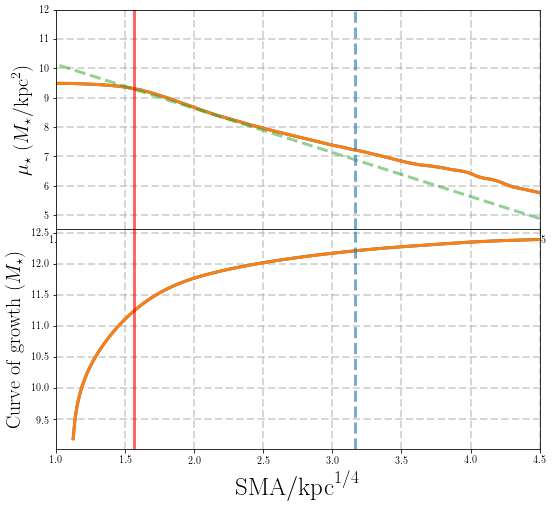

In [30]:
# 1-D mass density profile and the curve-of-growth of mass 

fig = plt.figure(figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                    left=0.13, bottom=0.10,
                    top=0.97, right=0.97)

ax1 = plt.subplot(2, 1, 1)
ax1.grid(linewidth=2.0, linestyle='--', alpha=0.5)

# Overplot a de Vaucouleurs plot with Re=24 kpc
dev = models.Sersic1D(amplitude=np.median(iso_cen_icl_3['intens'] / 9), 
                      r_eff=8, n=4.0)
ax1.plot((iso_cen_icl_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_icl_3['intens'] / 9.0), linewidth=3.0)
#plot central-only profile
ax1.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['intens'] / 9.0), linewidth=3.0)
ax1.plot((iso_cen_icl_3['sma'] * 3.0) ** 0.25, 
         np.log10(dev(iso_cen_icl_3['sma'])), linewidth=3.0, alpha=0.5,
         linestyle='--')
ax1.set_ylabel(r'$\mu_{\star}\ (M_{\star}/\mathrm{kpc}^2)$', fontsize=20)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.set_xlim(1.0, 4.5)

ax2 = plt.subplot(2, 1, 2)
ax2.grid(linewidth=2.0, linestyle='--', alpha=0.5)
ax2.plot((iso_cen_icl_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_icl_3['growth_ori']), linewidth=3.0)
ax2.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         np.log10(iso_cen_3['growth_ori']), linewidth=3.0)

ax2.set_ylabel(r'$\mathrm{Curve\ of\ growth}\ (M_{\star})$', fontsize=20)
ax2.set_xlabel(r'$\mathrm{SMA/kpc}^{1/4}$', fontsize=25)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax2.set_xlim(1.0, 4.5)

diff_growth=np.array(np.log10(iso_cen_icl_3['growth_ori'])-np.log10(iso_cen_3['growth_ori']))
print(diff_growth[diff_growth>0.0001])
diff_intens=np.array(np.log10(iso_cen_icl_3['intens'])-np.log10(iso_cen_3['intens']))
print(diff_intens[diff_intens>0.0001])

## show difference between cen and cen_icl

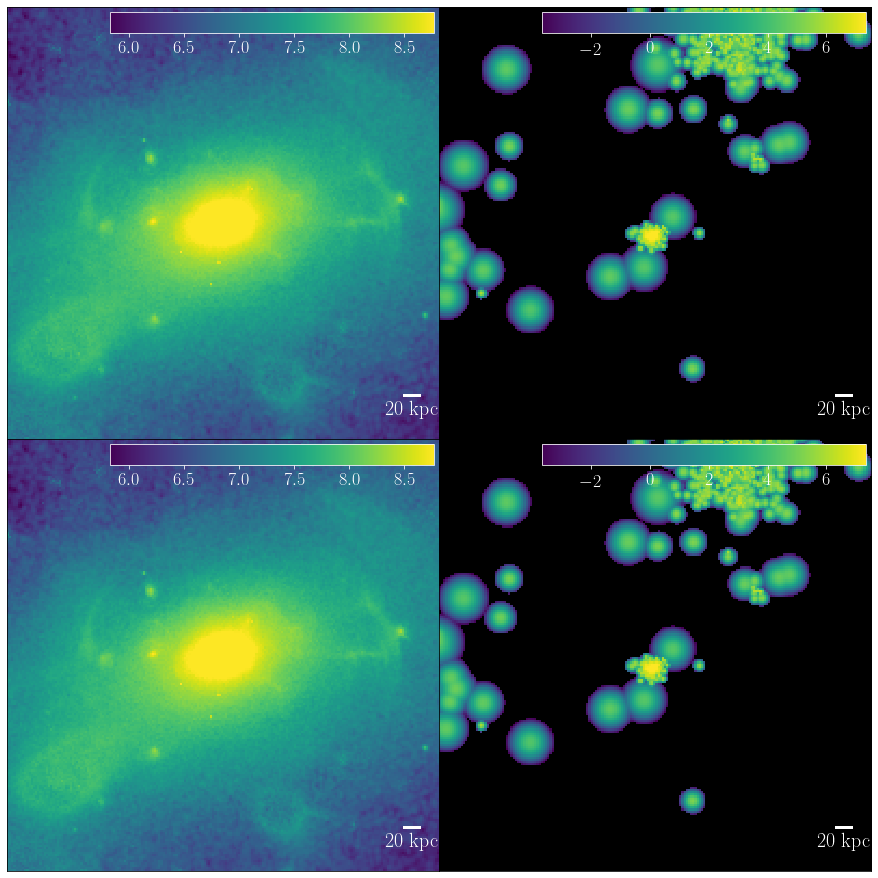

In [31]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.0, wspace=0.0, 
                        top=1.0, right=1.0, 
                        left=0.0, bottom=0.0)
ax1 = plt.subplot(2, 2, 1)
ax1 = display_single(img_cen, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
ax1 = plt.subplot(2, 2, 2)
ax1 = display_single(img_icl, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
ax1 = plt.subplot(2, 2, 3)
ax1 = display_single(img_cen_icl, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)
ax1 = plt.subplot(2, 2, 4)
ax1 = display_single(img_cen_icl - img_cen, ax=ax1, 
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=3.0,
                         color_bar=True)

# Save for later ...

(0.9, 4.5)

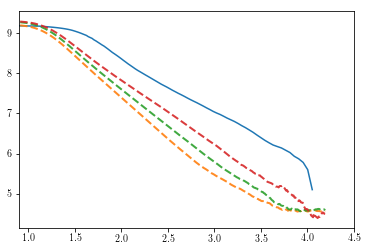

In [28]:
plt.plot((iso_cen_3['sma'] * 3.0) ** 0.25, 
         (iso_cen_3['sbp_cor'] / -2.5) + np.log10(0.7 ** 2.0))

## Median profiles from HSC
plt.plot(RSMA_COMMON, rm0_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)
plt.plot(RSMA_COMMON, rm1_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)
plt.plot(RSMA_COMMON, rm2_aml[2], linestyle='--', linewidth=2.0, 
         alpha=0.9, zorder=8)

plt.xlim(0.9, 4.5)

# Detect 36 objects


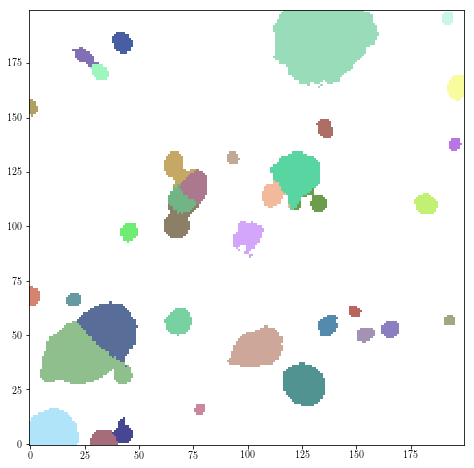

In [26]:
objs_sat, seg_sat = sep.extract(img_sat, 2.0,
                                err=bkg_cen.globalrms,
                                minarea=20, 
                                deblend_nthresh=48, deblend_cont=0.01,
                                segmentation_map=True)

seg_mask = (seg_sat > 0)
print("# Detect %d objects" % len(objs_sat))

plt.figure(figsize=(8, 8))
plt.imshow(seg_sat, origin='lower', cmap=SEG_CMAP, 
           alpha=0.9)